<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_Stacked_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [3]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [4]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


# 2º Passo: Cálculo do torque de interação τ_i

In [5]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
markov_t1['tau_i'] = Ka * (markov_t1['R_t_p'] - markov_t1['R_t_l']) + Ba * (markov_t1['R_w_p'] - markov_t1['R_w_l'])
markov_t1['d_tau_i'] = np.gradient(markov_t1['tau_i'])

# 3º Passo: Separação e Normalização dos dados


In [6]:
dataset = markov_t1.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase', 'R_T']].iloc[1450:]
y = dataset[['R_T']].iloc[1450:]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [7]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (10129, 420, 4)
Forma dos dados de saída: (10129, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [8]:
# Modelo Stacked Bidirectional LSTM
model_bilstm = Sequential()

# Primeira camada Bidirectional LSTM
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, n_features)))
model_bilstm.add(Dropout(0.3))

# Segunda camada Bidirectional LSTM
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm.add(Dropout(0.3))

# Camada final Bidirectional LSTM
model_bilstm.add(Bidirectional(LSTM(32, return_sequences=False)))
model_bilstm.add(Dropout(0.3))

# Camada densa final
model_bilstm.add(Dense(1))

# Compilar
model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=Huber(), metrics=['MAE', 'MSE'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 6º Passo: Treinamento do Modelo

In [9]:
# Treinamento
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=8, batch_size=64, validation_split=0.2)

Epoch 1/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - MAE: 0.1127 - MSE: 0.0266 - loss: 0.0133 - val_MAE: 0.0380 - val_MSE: 0.0022 - val_loss: 0.0011
Epoch 2/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - MAE: 0.0496 - MSE: 0.0041 - loss: 0.0020 - val_MAE: 0.0224 - val_MSE: 7.9708e-04 - val_loss: 3.9854e-04
Epoch 3/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - MAE: 0.0451 - MSE: 0.0034 - loss: 0.0017 - val_MAE: 0.0324 - val_MSE: 0.0015 - val_loss: 7.5378e-04
Epoch 4/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step - MAE: 0.0442 - MSE: 0.0033 - loss: 0.0016 - val_MAE: 0.0215 - val_MSE: 8.0068e-04 - val_loss: 4.0034e-04
Epoch 5/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - MAE: 0.0414 - MSE: 0.0029 - loss: 0.0014 - val_MAE: 0.0229 - val_MSE: 8.1170e-04 - val_loss: 4.0585e-04
Epoch 6/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - MAE: 0.0393 - MSE: 0.0026 - loss: 0.0013 - val_MAE: 0.0255 - val_MSE: 9.3580e-04 - val_loss: 4.6790e-04
Epoch 7/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - MAE: 0.038

# 7º Passo: Avaliação e Previsão

In [11]:
# Previsões
y_pred_bilstm = scaler_y.inverse_transform(model_bilstm.predict(X_train))
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas BiLSTM
r2_bilstm = r2_score(y_train_rescaled, y_pred_bilstm)
mae_bilstm = mean_absolute_error(y_train_rescaled, y_pred_bilstm)
rmse_bilstm = np.sqrt(mean_squared_error(y_train_rescaled, y_pred_bilstm))

print("\nResultados Stacked BiLSTM:")
print(f'R²: {r2_bilstm}, MAE: {mae_bilstm}, RMSE: {rmse_bilstm}')

317/317 ━━━━━━━━━━━━━━━━━━━━ 229s 722ms/step

Resultados Stacked BiLSTM:
R²: 0.9760155150533062, MAE: 0.37835478166733044, RMSE: 0.4646139867345401


# 8º Passo: Visualização das perdas (train vs validation)

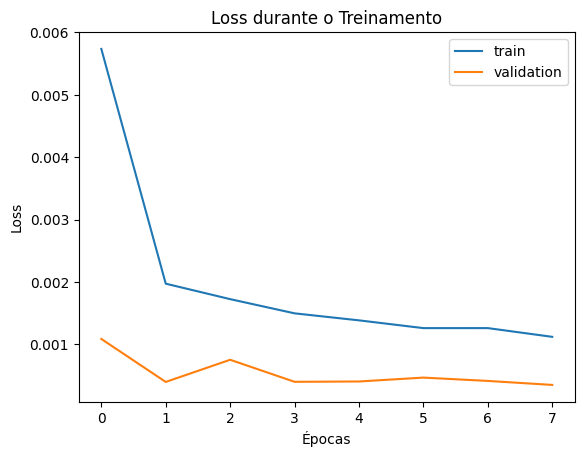

In [13]:
plt.plot(history_bilstm.history['loss'], label='train')
plt.plot(history_bilstm.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

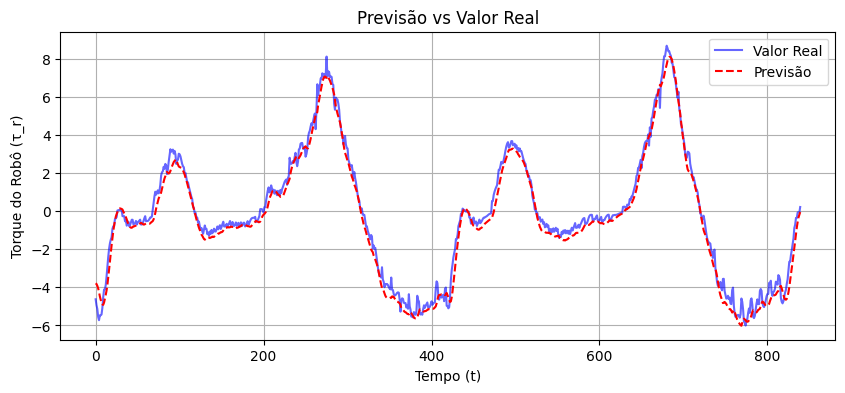

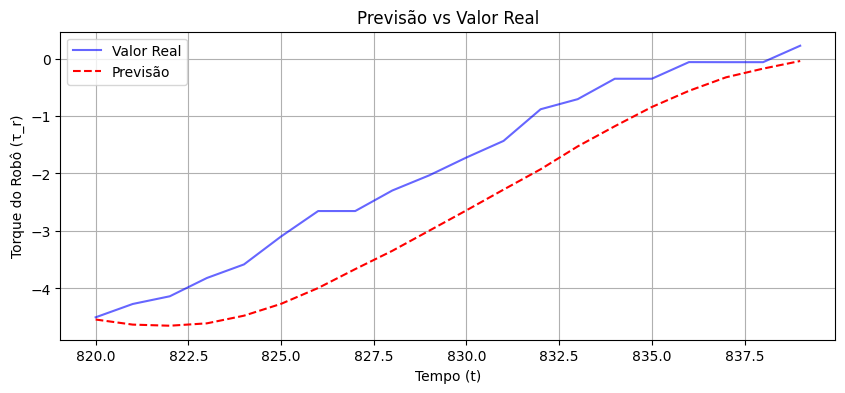

In [33]:
cursor1 = 820
cursor2 = 840

# Criar o eixo X para o intervalo específico
x_range = np.arange(cursor1, cursor2)

# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot( y_train_rescaled.flatten()[0:cursor2], label='Valor Real', color='blue', alpha=0.6)
plt.plot( y_pred_bilstm.flatten()[0:cursor2], label='Previsão', color='red', linestyle='--', alpha=1)
plt.title('Previsão vs Valor Real')
plt.xlabel('Tempo (t)')
plt.ylabel('Torque do Robô (τ_r)')
plt.legend()
plt.grid(True)
plt.show()

# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(x_range, y_train_rescaled.flatten()[cursor1:cursor2], label='Valor Real', color='blue', alpha=0.6)
plt.plot(x_range, y_pred_bilstm.flatten()[cursor1:cursor2], label='Previsão', color='red', linestyle='--', alpha=1)
plt.title('Previsão vs Valor Real')
plt.xlabel('Tempo (t)')
plt.ylabel('Torque do Robô (τ_r)')
plt.legend()
plt.grid(True)
plt.show()


# 10º Passo: Erro

In [17]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred_bilstm.flatten()

#11º Passo: Plot do Erro

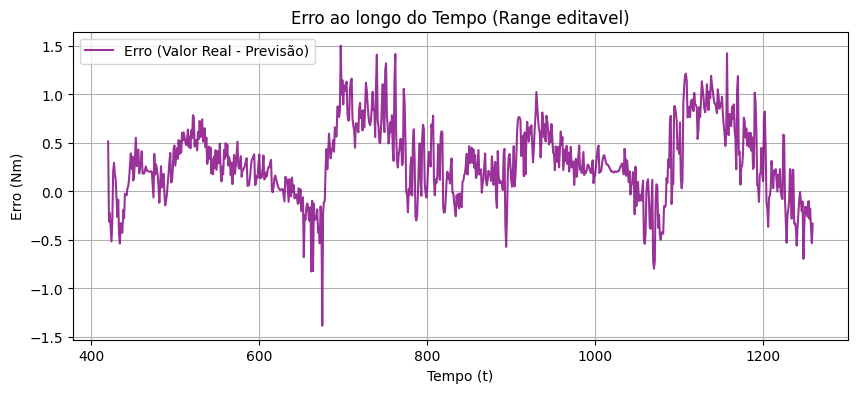

Média do Erro: nan Nm
Desvio Padrão do Erro: nan Nm


In [113]:
cursor1 = 420
cursor2 =1260

# Criar o eixo X para o intervalo específico
x_range = np.arange(cursor1, cursor2)

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(x_range, erro[cursor1:cursor2], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

#12º Passo: Deslocamento

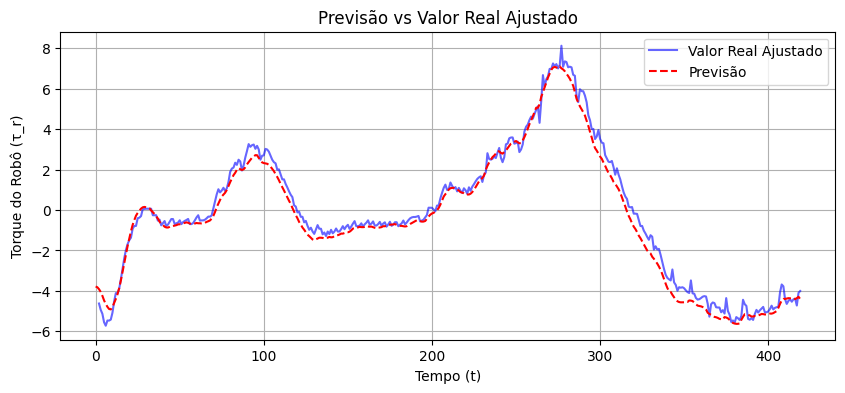

In [109]:
cursor1 = 0
cursor2 = 420


# Criar o y_train_adjusted (com deslocamento de 2 pontos)
offset = 14//5
y_train_adjusted = np.empty_like(y_train_rescaled.flatten())
y_train_adjusted[:offset] = np.nan  # Preencher com NaN nos primeiros 2 pontos
y_train_adjusted[offset:] = y_train_rescaled.flatten()[:-offset]  # Deslocar os valores para a esquerda

# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(y_train_adjusted[cursor1:cursor2], label='Valor Real Ajustado', color='blue', alpha=0.6)
plt.plot(y_pred_bilstm.flatten()[cursor1:cursor2], label='Previsão', color='red', linestyle='--', alpha=1)
plt.title('Previsão vs Valor Real Ajustado')
plt.xlabel('Tempo (t)')
plt.ylabel('Torque do Robô (τ_r)')
plt.legend()
plt.grid(True)
plt.show()


#13º Erro com deslocamento

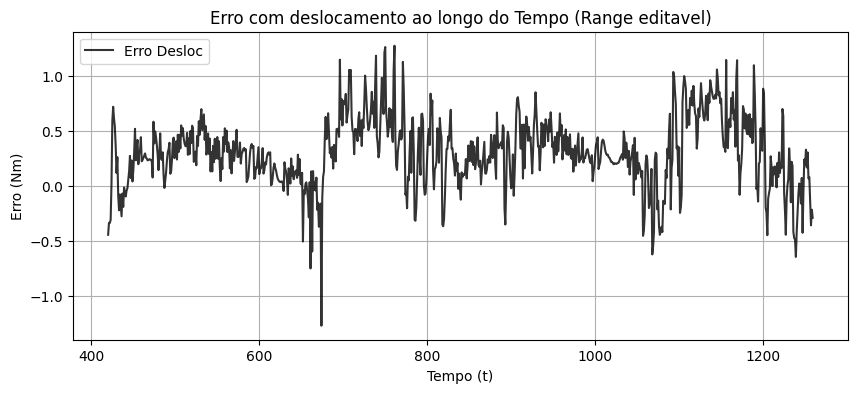

In [112]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro2 =y_train_adjusted.flatten() - y_pred_bilstm.flatten()

cursor1 = 420
cursor2 = 1260

# Criar o eixo X para o intervalo específico
x_range = np.arange(cursor1, cursor2)

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(x_range, erro2[cursor1:cursor2], label='Erro Desloc', color='black', alpha=0.8)
# plt.plot(x_range, erro[cursor1:cursor2], label='Erro', color='purple', linestyle='--',alpha=0.8)
plt.title('Erro com deslocamento ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()